# Model v14

This model was trained and tested with images validated to contain a path (second round of validation).

Roughness metric = 1 second ahead, k-means 4.

## Set-up

In [ ]:
!pip install wandb

     |████████████████████████████████| 1.8MB 12.7MB/s 
     |████████████████████████████████| 163kB 53.3MB/s 
     |████████████████████████████████| 81kB 13.2MB/s 
     |████████████████████████████████| 133kB 61.6MB/s 
     |████████████████████████████████| 102kB 15.4MB/s 
     |████████████████████████████████| 71kB 9.4MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp36-none-any.whl size=6490 sha256=a562909fc2539ba792c14deaf21351535810a4d68eb08dc153aa32eada11a70d
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
Successfully built subprocess32


In [ ]:
!pip install "torch==1.4" "torchvision==0.5.0"

     |████████████████████████████████| 753.4MB 21kB/s 
     |████████████████████████████████| 4.0MB 33.2MB/s 
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
  Found existing installation: torchvision 0.8.1+cu101
    Uninstalling torchvision-0.8.1+cu101:
      Successfully uninstalled torchvision-0.8.1+cu101


In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
!ls '/gdrive/My Drive/Labeling/Model/'

ImageFolder.ipynb  Models.gdoc	v10  v12  v14  v9
Images		   Previous	v11  v13  v8


In [ ]:
from fastai.vision import *
import pandas as pd
import numpy as np
import os

In [ ]:
import wandb
from wandb.fastai import WandbCallback

wandb.init(project='roughness-classifier-2')

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Model with `get_transforms(do_flip=False)`

#### Load data

In [ ]:
path = '/gdrive/My Drive/Labeling/Model'
folder_path = os.path.join(path, 'v14')
image_path = os.path.join(path, 'Images')
label_path = '/gdrive/My Drive/Labeling/LabelsCSV/random_split/Metric2'

In [ ]:
df = pd.read_csv(os.path.join(label_path, 'all_labels_path_metric_2_train.csv'))
df = df.filter(items=['image', 'group_4'])
df['group_4'] = df['group_4'].astype(int).astype(str)
df.head()

,image,group_4
0,969902383s228ms.jpg,0
1,969902516s227ms.jpg,0
2,969902832s243ms.jpg,0
3,970330409s202ms.jpg,1
4,969901887s232ms.jpg,1


In [ ]:
print('All images:', len(os.listdir(image_path)))
print('Images in Path folder', len(os.listdir('/gdrive/My Drive/Labeling/PathDetectionClassifier/PredictImages/Path')))
print('Images in CSV (80% of Path folder):', len(df))

All images: 8983
Images in Path folder 7070
Images in CSV (80% of Path folder): 5647


#### Balance classes

In [ ]:
group_0 = df[df['group_4'] == '0']
group_1 = df[df['group_4'] == '1']
group_2 = df[df['group_4'] == '2']
group_3 = df[df['group_4'] == '3']

print(len(group_0))
print(len(group_1))
print(len(group_2))
print(len(group_3))

2386
2099
897
265


In [ ]:
group_0 = group_0[:1000]
group_1 = group_1[:1000]

df_balanced = group_0.append(group_1).append(group_2).append(group_3)

print(len(df_balanced))
print(len(df_balanced[df_balanced['group_4'] == '0']))
print(len(df_balanced[df_balanced['group_4'] == '1']))
print(len(df_balanced[df_balanced['group_4'] == '2']))
print(len(df_balanced[df_balanced['group_4'] == '3']))

3162
1000
1000
897
265


#### DataBunch

The original image size is 3840 x 2160. We resize (squish) to a smaller image with the same aspect ratio (270 x 480, decreased by a factor of 8) [Link](https://fastai1.fast.ai/vision.transform.html#Data-augmentation-details).

In [ ]:
bs = 64
# bs = 16    # uncomment this line if you run out of memory

In [ ]:
np.random.seed(42)
data = (ImageList
        .from_df(path=image_path, df=df_balanced)
        .split_by_rand_pct(0.2)
        .label_from_df()
        .transform(get_transforms(do_flip=False), size=(270,480))
        .databunch(bs=bs)
        .normalize())

In [ ]:
train_x = data.train_ds.x
train_y = data.train_ds.y
valid_x = data.valid_ds.x
valid_y = data.valid_ds.y

print(len(train_x), len(train_y))
print(len(valid_x), len(valid_y))

2530 2530
632 632


In [ ]:
print(data.classes)

['0', '1', '2', '3']


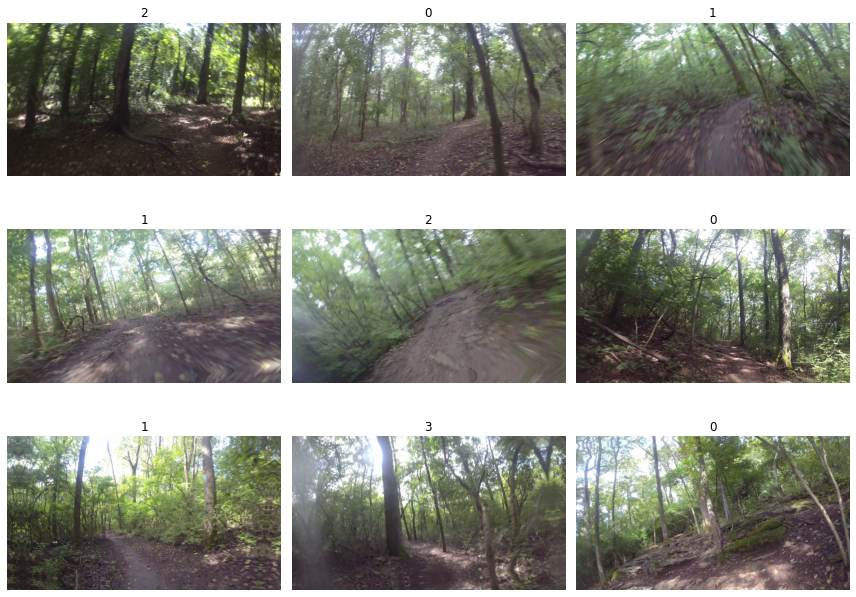

In [ ]:
data.show_batch(rows=3, figsize=(12,9))

#### ResNet50

In [ ]:
arch = models.resnet50
learn = cnn_learner(data, arch, metrics=[accuracy], callback_fns=WandbCallback)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


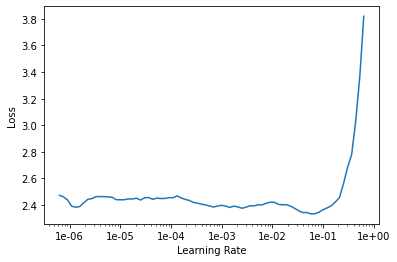

In [ ]:
learn.recorder.plot()

In [ ]:
lr = 0.01

In [ ]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,2.227800,1.870863,0.395570,12:11
1,1.728928,1.427544,0.411392,11:18
2,1.505696,1.359291,0.412975,10:54
3,1.333857,1.220265,0.420886,10:56
4,1.199461,1.165493,0.465190,10:51


Better model found at epoch 0 with valid_loss value: 1.8708627223968506.
Better model found at epoch 1 with valid_loss value: 1.427544355392456.
Better model found at epoch 2 with valid_loss value: 1.3592907190322876.
Better model found at epoch 3 with valid_loss value: 1.2202645540237427.
Better model found at epoch 4 with valid_loss value: 1.1654925346374512.
Loaded best saved model from /content/wandb/run-20201226_141713-s3epry89/files/bestmodel.pth


In [ ]:
learn.save(os.path.join(folder_path, 'v14-stage-1'))

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

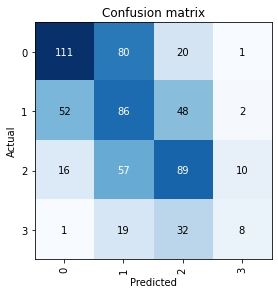

In [ ]:
interp.plot_confusion_matrix()

In [ ]:
learn.load(os.path.join(folder_path, 'v14-stage-1'))

In [ ]:
learn.fit_one_cycle(2, slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,1.186162,1.332652,0.450949,10:54
1,1.206496,1.216001,0.447785,10:57


Better model found at epoch 0 with valid_loss value: 1.33265221118927.
Better model found at epoch 1 with valid_loss value: 1.2160011529922485.
Loaded best saved model from /content/wandb/run-20201226_141713-s3epry89/files/bestmodel.pth


#### Fine-tune

In [ ]:
bs = 16    # uncomment this line if you run out of memory
learn.data.batch_size = 16

In [ ]:
learn.data.batch_size

16

In [ ]:
learn.load(os.path.join(folder_path, 'v14-stage-1'))

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


Loaded best saved model from /content/wandb/run-20201226_141713-s3epry89/files/bestmodel.pth
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


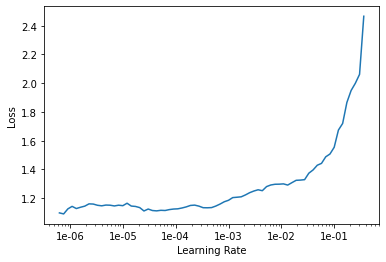

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(5, slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,1.110470,1.176474,0.458861,11:02
1,1.115938,1.149418,0.474684,11:04
2,1.070587,1.128265,0.484177,11:05
3,1.074477,1.115472,0.490506,11:06
4,1.004007,1.129283,0.490506,11:33


Better model found at epoch 0 with valid_loss value: 1.1764737367630005.
Better model found at epoch 1 with valid_loss value: 1.1494183540344238.
Better model found at epoch 2 with valid_loss value: 1.1282650232315063.
Better model found at epoch 3 with valid_loss value: 1.1154717206954956.
Loaded best saved model from /content/wandb/run-20201226_141713-s3epry89/files/bestmodel.pth


In [ ]:
learn.save(os.path.join(folder_path, 'v14-stage-2'))

In [ ]:
learn.freeze()

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

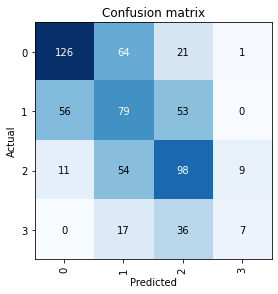

In [ ]:
interp.plot_confusion_matrix()

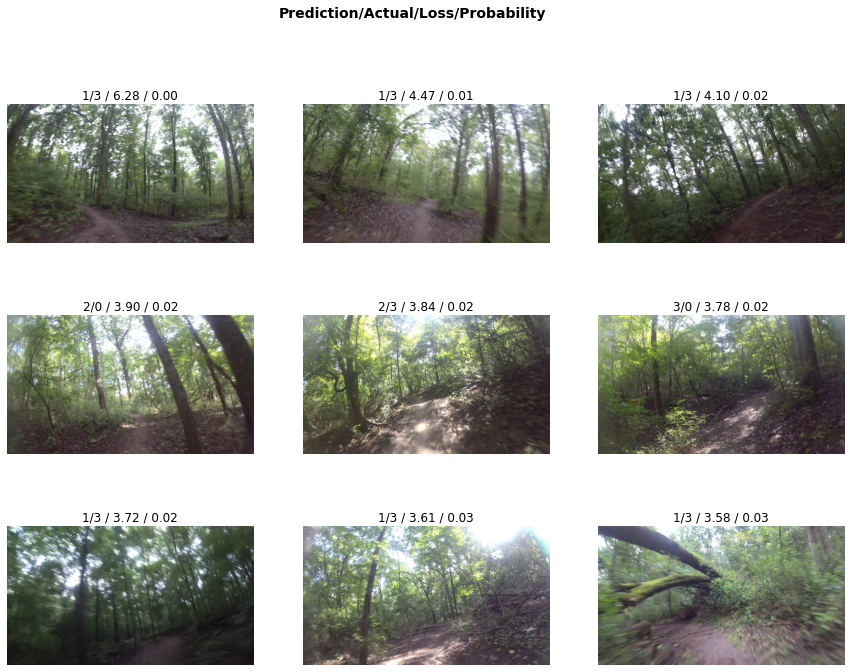

In [ ]:
 interp.plot_top_losses(9, figsize=(15,11))